In [1]:
from load_dataset.artgraph import ArtGraph
import torch_geometric.transforms as T
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import copy
import torch
from torch_geometric.nn import HeteroConv, GATConv
from torch.nn import Linear
import torch.nn.functional as F
from torch import nn
import os
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Model, ModelClassification
from torch.utils.data import WeightedRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
from model import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## UTILS

In [4]:
from utils.GraphLinkSplitter import GraphLinkSplitter
#useful function to avoid frequent generation of the splitted dataset (expensive computational cost)
def import_dataset(root, feat, fine_tuning, obj, device, val_size = 0.2, test_size = 0.1):
    fine_tuning_s = 'fine-tuning' if fine_tuning else ''
    if (not os.path.exists(root)) or (not list(filter(lambda x: x.endswith(f'{obj}_{feat}_{fine_tuning_s}.pt'),os.listdir(root)))):
        if not os.path.exists(root):
            os.makedirs(root)
        artgraph = ArtGraph(root = 'artgraph2bestemotions', preprocess='constant', features = feat, fine_tuning=fine_tuning)
        data = artgraph[0]
        data = T.ToUndirected()(data)
        del data[(obj, 'artwork')]
        gls = GraphLinkSplitter(on=obj, seed = 1, val_size = val_size, test_size = test_size)
        train_data, val_data, test_data = gls.transform(data)
        torch.save(train_data, fr'{root}/train_data_{obj}_{feat}_{fine_tuning_s}.pt')
        torch.save(val_data, fr'{root}/val_data_{obj}_{feat}_{fine_tuning_s}.pt')
        torch.save(test_data, fr'{root}/test_data_{obj}_{feat}_{fine_tuning_s}.pt')
    else:
        train_data=torch.load(fr'{root}/train_data_{obj}_{feat}_{fine_tuning_s}.pt')
        val_data=torch.load(fr'{root}/val_data_{obj}_{feat}_{fine_tuning_s}.pt')
        test_data=torch.load(fr'{root}/test_data_{obj}_{feat}_{fine_tuning_s}.pt')
    return train_data.to(device), val_data.to(device), test_data.to(device)

In [5]:
#class to manage the dataset (artwork features-style)
class ClassificationDataSet(torch.utils.data.Dataset):
    def __init__(self, graph, sub = 'artwork', obj = 'style'):
        self.graph = graph
        self.data = graph[sub, obj].edge_label_index.T[graph[sub, obj].edge_label==1]
        self.sub = sub
        self.obj = obj
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,0], self.graph[self.sub].x[self.data[idx,0]], self.data[idx, 1]
    
    def get_links(self):
        return pd.DataFrame(self.data.cpu().numpy(), columns = [self.sub, self.obj])

In [6]:
#to avoid class imbalance
def get_sampler(links, obj):
    unique, counts = np.unique(links[obj], return_counts = True)
    weights = [sum(counts) / c for c in counts]
    example_weights = [weights[e] for e in links[obj]]
    return WeightedRandomSampler(example_weights, links[obj].shape[0], replacement=True)

In [7]:
#to manage the training phase
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0.001):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, current_loss):
        if self.best_loss == None:
            self.best_loss = current_loss
        elif (current_loss - self.best_loss) < -self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait = self.wait + 1
            print(f"INFO: Early stopping counter {self.wait} of {self.patience}")
            if self.wait >= self.patience:
                self.early_stop = True

In [8]:
#training function
#TIPS: if you need a new one, take this structure and change just the internal loop, depending on the task
def fine_tune(model, train_loader, validation_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 100,
              update_graph = False):
    best_model = copy.deepcopy(model)
    best_acc = 0.0
    best_epoch=0
    
    stop = False
    for epoch in range(1, num_epochs + 1):
        if stop:
            break
        print(f'Epoch {epoch}/{num_epochs}')
        print('-'*120)

        data_loader = None
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = copy.deepcopy(validation_loader)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idxs, inputs, labels in tqdm(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(data_loader.dataset.graph.x_dict, data_loader.dataset.graph.edge_index_dict, inputs)
                    _, preds = torch.max(nn.Softmax(dim = 1)(outputs), 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if update_graph and phase == 'val':
                    data_loader.dataset.graph[data_loader.dataset.sub, data_loader.dataset.obj].edge_index = \
                        torch.hstack([data_loader.dataset.graph[data_loader.dataset.sub, data_loader.dataset.obj]\
                                                                     .edge_index,
                                                                 torch.Tensor([idxs.tolist(), preds.cpu().tolist()]).to(device)]).type(torch.long)
                    #artwork-task node
            epoch_loss = running_loss / (len(data_loader) * data_loader.batch_size)
            epoch_acc = running_corrects.double() / (len(data_loader) * data_loader.batch_size)
                
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model = copy.deepcopy(model)
                
                
            if phase == 'val':
                scheduler.step(epoch_acc.item())
            if phase == 'val':
                early_stop(-epoch_acc.item())
                print('-'*120, end = '\n\n')
                stop=early_stop.early_stop
                
                
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best epoch: {best_epoch:03d}')

    # load best model 
    return best_model, best_acc

In [9]:
#for metrics
def get_topk(k, artwork, probabilities):
    p = sorted(list(map(lambda x: (x[1], x[0], ), enumerate(probabilities))), reverse = True)
    ans = []
    for idx in range(k):
        ans.append((artwork, p[idx][1], ))
    return ans

In [10]:
#to perform graph update, during the testing phase
def add_links(graph, sub, obj, artworks, outputs, topk, device = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device == None else device
    work_graph = copy.deepcopy(graph)
    zipped = list(zip(artworks.tolist(), outputs.cpu().tolist()))
    top_task_pairs = list(map(lambda x: get_topk(topk, x[0], x[1]), zipped))
    top_task_pairs = torch.Tensor(top_task_pairs).type(torch.long)
    top_task_pairs = top_task_pairs.reshape(top_task_pairs.size(0) * top_task_pairs.size(1), top_task_pairs.size(2)).T
    work_graph[sub, obj].edge_index = torch.hstack([work_graph[sub, obj].edge_index.cpu(), top_task_pairs]).to(device)
    return work_graph

In [11]:
#test function
def test(model, test_loader, update_graph=True, track_history = False, topk = 1):
    corrects = 0
    tot_pred = None
    tot_lab = []
    history = []
    for idxs, inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(test_loader.dataset.graph.x_dict, test_loader.dataset.graph.edge_index_dict, inputs)
            outputs = nn.Softmax(dim = 1)(outputs)
            if tot_pred is None:
                tot_pred = outputs.cpu()
            else:
                tot_pred = torch.vstack([tot_pred, outputs.cpu()])
            tot_lab += labels.cpu().tolist()
        if update_graph:
            test_loader.dataset.graph = add_links(test_loader.dataset.graph,
                                                     test_loader.dataset.sub,
                                                     test_loader.dataset.obj,
                                                     idxs,
                                                     outputs,
                                                     topk,
                                                    )
        if track_history:
            lab_pred = torch.max(outputs, dim = 1)[1]
            history.append(((lab_pred == labels).sum() / labels.size(0)).item())
    
    if track_history:
        return tot_lab, tot_pred, history
    return tot_lab, tot_pred

## NORMAL LEARNING

In [ ]:
#normal learning-> without updating the graph
batch_size = 128
update_graph = False
res = {}
if not os.path.exists('res_classification/normal'):
    os.makedirs('res_classification/normal')
for task in ('emotion', 'style', 'genre'):
    print(f"{'*'*50}{task.upper()}{'*'*50}")
    train_data, val_data, test_data = import_dataset(root = 'dataset_full_conf', feat='vit', fine_tuning=True,
                                                                 obj=task, device=device)
    model = ModelClassification(train_data, hidden_channels = 128,
                           obj= task, head_num_layers = 5, gnn_activation = nn.Tanh(),
                           head_activation = nn.LeakyReLU, shared = True, gnn_mean = False, bnorm = False,
                           drop_rate = 0.25).to(device)
    
    train_dataset = ClassificationDataSet(train_data, obj = task)
    val_dataset = ClassificationDataSet(val_data, obj = task)
    test_dataset = ClassificationDataSet(test_data, obj = task)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)
    #initialize encoders parameters
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'max', min_lr = 1e-7, verbose = True, factor = .5, patience = 2,
                                               threshold = 1e-4)
    early_stop= EarlyStopping(patience = 7, min_delta = -1e-4)
    best_model, best_acc=fine_tune(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 50,
                                  update_graph = False)
    #torch.save(best_model, fr'res_classification/normal/{task}.pt')
    res[task] = best_acc.item()

**************************************************EMOTION**************************************************


Processing...
Done!


doing training
doing validation
doing test
doing edge label


D:\Anaconda\envs\tesi\lib\site-packages\torch_geometric\nn\conv\hetero_conv.py:53: UserWarning: There exist node types ({'artwork'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:10<00:00, 34.89it/s]


train Loss: 1.7615 Acc: 0.3804


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 74.71it/s]


val Loss: 1.6145 Acc: 0.4202
------------------------------------------------------------------------------------------------------------------------

Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.44it/s]


train Loss: 1.6324 Acc: 0.4204


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 81.07it/s]


val Loss: 1.5932 Acc: 0.4273
------------------------------------------------------------------------------------------------------------------------

Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


 27%|█████████████████████▊                                                           | 96/357 [00:01<00:05, 50.10it/s]

In [13]:
res

{'emotion': 0.4456188725490196,
 'style': 0.5758499313186813,
 'genre': 0.7167324862637363}

In [14]:
import json
with open('res_classification/results.json','w') as f:
    json.dump(res,f)

## TESTING

In [13]:
history_map = {}

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#plot confusion matrix
def plot_confusion_matrix(true, pred, task = None, strategy=None , labels = None, hop = 1):
    conf_mat = confusion_matrix(true, pred, normalize = 'true')
    sns.set(font_scale=1.5) # for label size
    fig, ax = plt.subplots(figsize = (12,12))
    
    ax = sns.heatmap(pd.DataFrame(conf_mat), annot = False, cmap = plt.cm.Blues,
                     xticklabels = labels,
                     yticklabels = labels,
                     square = True,
                     linewidths=.50)
    
    plt.show()
    if task:
        fig.savefig(f'{task}_{strategy}.svg')

In [15]:
def compute_topk(true, pred, k):
    #target data frame to compute topk
    df = pd.DataFrame(true, columns = ['true'])
    #useful dataframe to compute top k target for each artwork
    temp = pd.DataFrame(pd.DataFrame(pred).apply(lambda x: x.tolist(), axis = 1), columns = ['pred'])
    temp['temp'] = temp.pred.map(lambda x: list(range(len(x))))#for each artwork list of classes
    temp['temp'] = temp.apply(lambda x: list(zip(x['pred'], x['temp'])), axis = 1)#zip probabilities with classes
    temp['topk'] = temp['temp'].map(lambda x: list(sorted(x, reverse = True))[:k])#sorting
    df['topk'] = temp.topk.map(lambda x: list(map(lambda y: y[1], x)))#taking only classes
    
    df['cond'] = df.apply(lambda x: x['true'] in x['topk'], axis = 1)
    return df[df.cond].index.shape[0] / df.index.shape[0]
    

In [16]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:01<00:00, 46.86it/s]


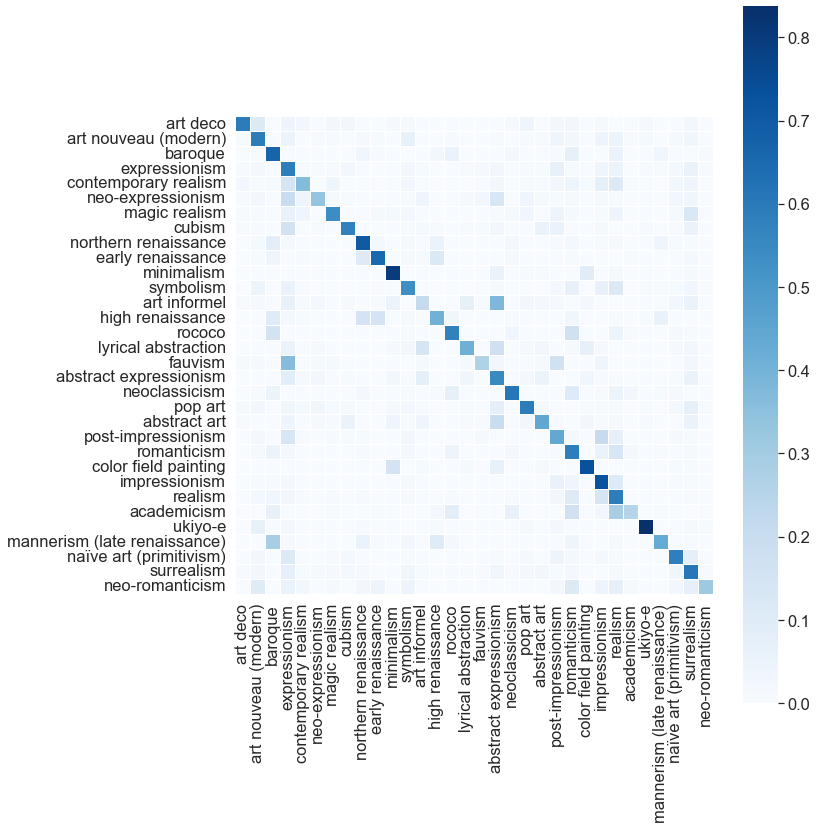

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:02<00:00, 44.23it/s]


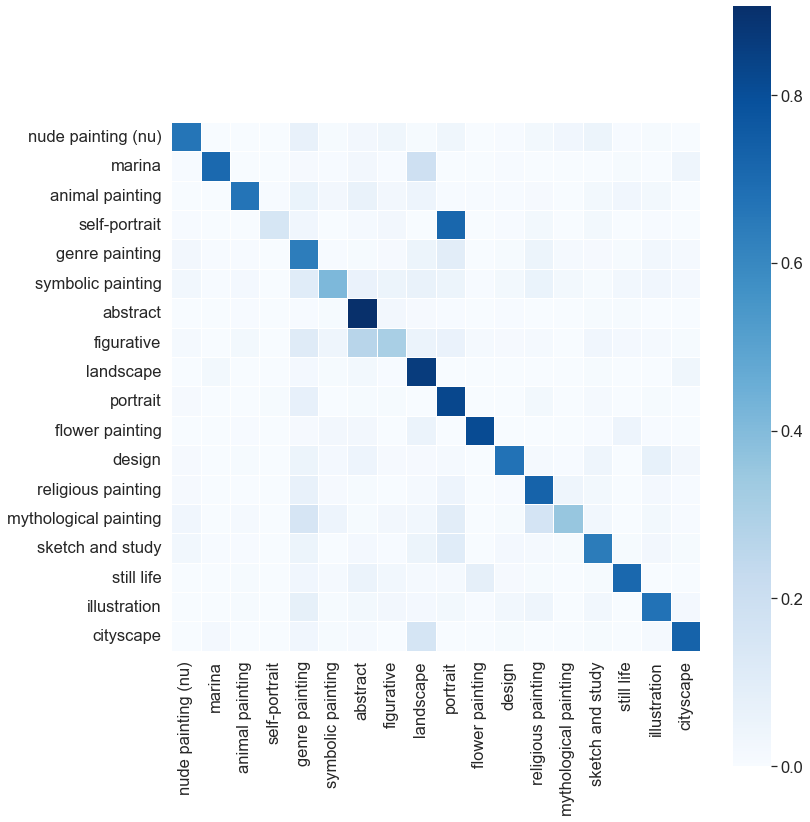

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 41.26it/s]


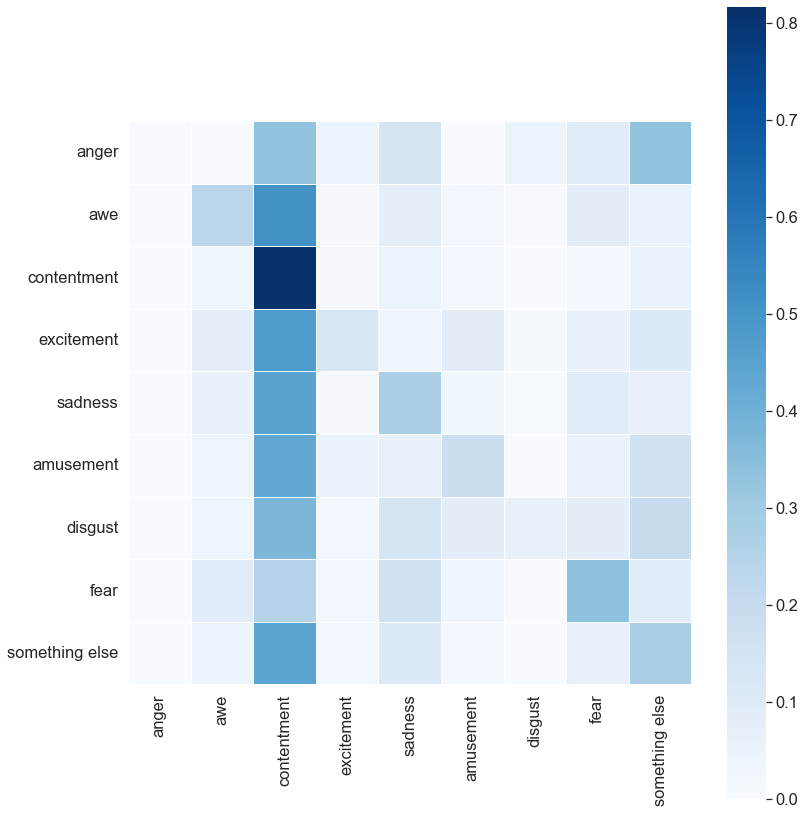

In [27]:
#testing without updating the graph
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
batch_size = 128
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    model = torch.load(fr'res_classification/normal/{task}.pt').to(device)
    
    task2name = pd.read_csv(f'artgraph2bestemotions/mapping/{task}_entidx2name.csv', names = ['idx','name'])
    names = task2name['name'].values
    
    test_data = torch.load(fr'dataset_full_conf/test_data_{task}_vit_fine-tuning.pt').to(device)
    test_dataset = ClassificationDataSet(test_data, obj = task)
    test_loader = test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                   drop_last=False, worker_init_fn=np.random.seed(1))
    
    true, pred, history = test(model, test_loader, update_graph = False, track_history = True)
    
    if task == 'genre':
        history_map['normal_no_update'] = history
    pred = pred.numpy()
    results_df['Top1'].loc[task] = compute_topk(true, pred, 1)
    results_df['Top2'].loc[task] = compute_topk(true, pred, 2)
    pred = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(true, pred, average = 'macro')
    plot_confusion_matrix(true, pred, task = task, strategy = 'normal', labels = task2name['name'], hop = map_hop[task])
    #ConfusionMatrixDisplay.from_predictions(true, pred, normalize = 'true', include_values = False)
    plt.show()

In [28]:
results_df

,Top1,Top2,Macro-F1
style,0.582933,0.754293,0.545326
genre,0.723043,0.862895,0.642681
emotion,0.451717,0.642857,0.270228


In [29]:
results_df.to_csv('res_classification/normal_no_update.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 29.44it/s]


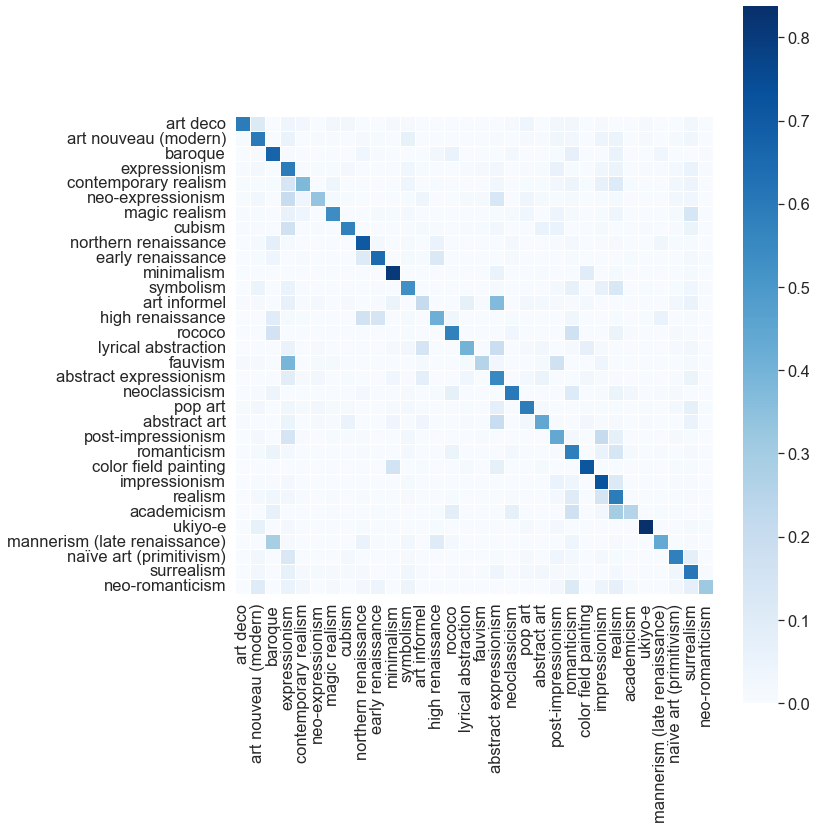

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 27.28it/s]


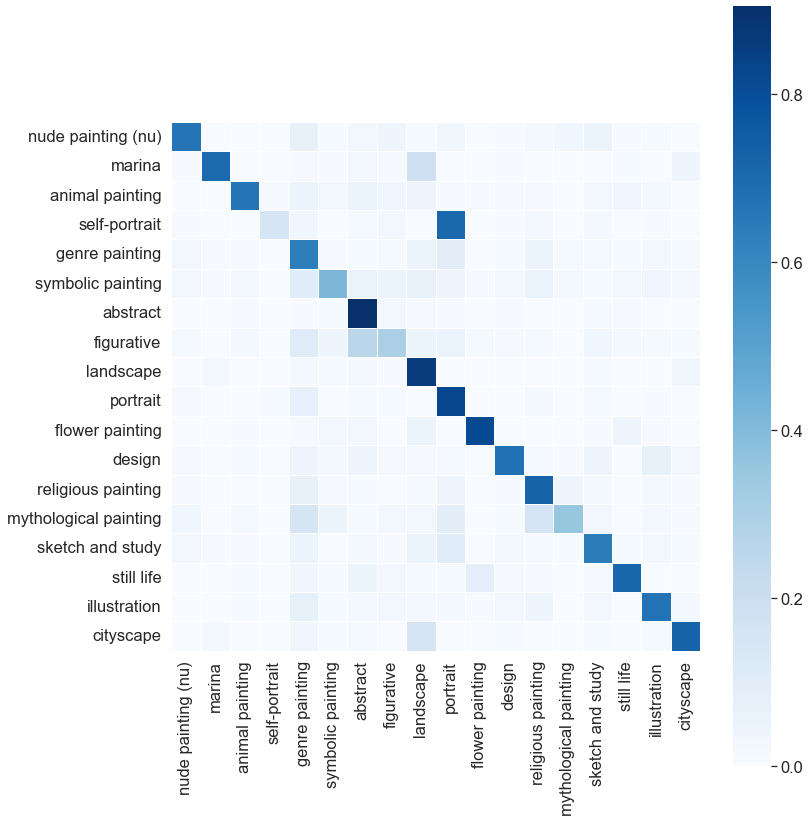

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 23.36it/s]


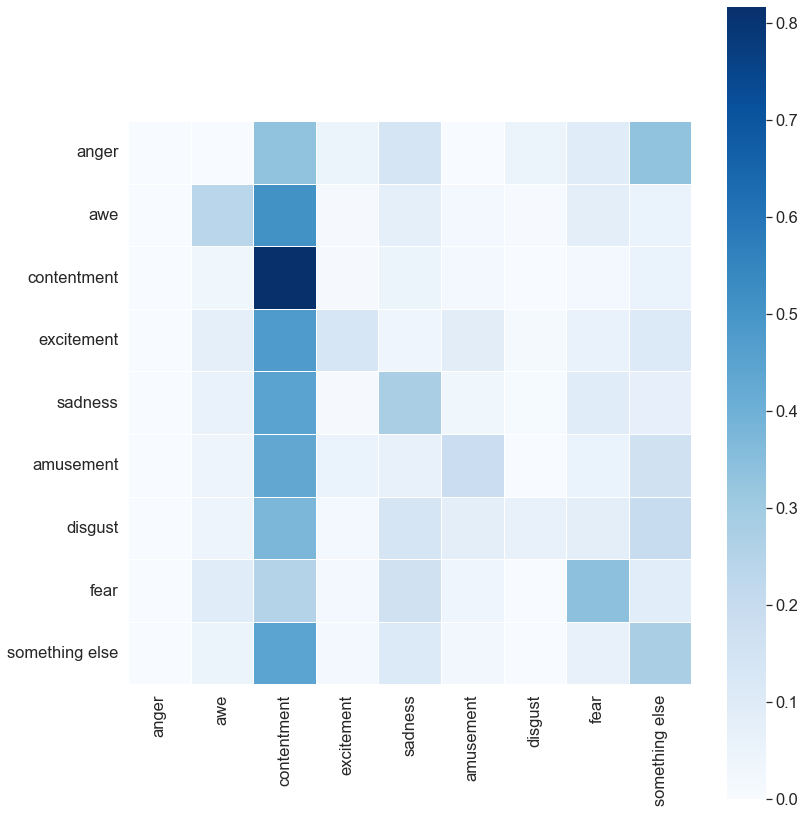

In [30]:
#testing updating the graph
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
batch_size = 128
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    model = torch.load(fr'res_classification/normal/{task}.pt').to(device)
    
    task2name = pd.read_csv(f'artgraph2bestemotions/mapping/{task}_entidx2name.csv', names = ['idx','name'])
    
    test_data = torch.load(fr'dataset_full_conf/test_data_{task}_vit_fine-tuning.pt').to(device)
    test_dataset = ClassificationDataSet(test_data, obj = task)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                   drop_last=False)
    
    true, pred, history = test(model, test_loader, update_graph = True, track_history=True, topk = 1)
    
    if task == 'genre':
        history_map['normal_update'] = history
    pred = pred.numpy()
    results_df['Top1'].loc[task] = compute_topk(true, pred, 1)
    results_df['Top2'].loc[task] = compute_topk(true, pred, 2)
    pred = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(true, pred, average = 'macro')
    plot_confusion_matrix(true, pred, task = task, strategy = 'update', labels = task2name['name'], hop = map_hop[task])
    #ConfusionMatrixDisplay.from_predictions(true, pred, normalize = 'true', include_values = False)
    plt.show()

In [24]:
results_df

,Top1,Top2,Macro-F1
style,0.582761,0.753606,0.545753
genre,0.722442,0.862809,0.642405
emotion,0.451563,0.641937,0.270919


In [25]:
results_df.to_csv('res_classification/normal_update.csv')